**1. Import Libraries**

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

**2. Load and Preprocess Images and Masks**

In [3]:
image_dir = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"
images = []
masks = []

all_folders = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]

for folder in all_folders:
    folder_path = os.path.join(image_dir, folder)
    files = sorted(os.listdir(folder_path))
    
    for f in files:
        if "mask" in f.lower():
            mask_path = os.path.join(folder_path, f)
            image_name = f.replace('_mask', '')
            image_path = os.path.join(folder_path, image_name)

            if os.path.exists(image_path):
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                if img is not None and mask is not None:
                    img = cv2.resize(img, (128, 128)) / 255.0
                    mask = cv2.resize(mask, (128, 128)) / 255.0

                    images.append(img[..., np.newaxis])
                    masks.append(mask[..., np.newaxis])

X = np.array(images)
y = np.array(masks)

**3. Train-Validation Split**

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Total folders:", len(all_folders))
print("Total images loaded:", len(images))
print("Total masks loaded:", len(masks))
print("Shape of image dataset (X):", X.shape)
print("Shape of mask dataset (y):", y.shape)
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Total folders: 110
Total images loaded: 3929
Total masks loaded: 3929
Shape of image dataset (X): (3929, 128, 128, 1)
Shape of mask dataset (y): (3929, 128, 128, 1)
Train set shape: (3143, 128, 128, 1) (3143, 128, 128, 1)
Validation set shape: (786, 128, 128, 1) (786, 128, 128, 1)


**4. Show Random Samples**

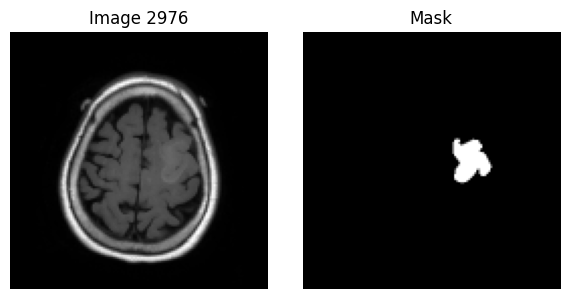

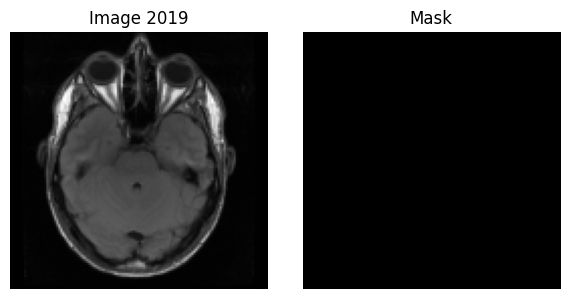

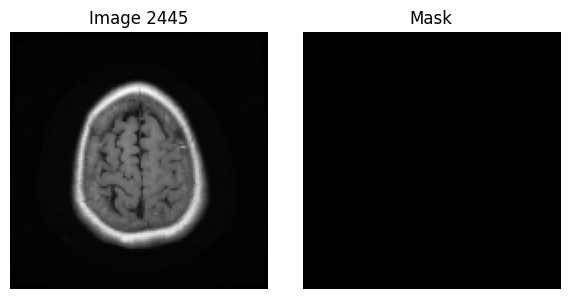

In [5]:
import random

def show_sample(index):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X[index].squeeze(), cmap='gray')
    plt.title(f"Image {index}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(y[index].squeeze(), cmap='gray')
    plt.title("Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

random_indices = random.sample(range(len(X)), 3)
for idx in random_indices:
    show_sample(idx)

**5. Define U-Net Model**

In [6]:
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    p3 = MaxPooling2D()(c3)

    b = Conv2D(128, 3, activation='relu', padding='same')(p3)

    u1 = Conv2DTranspose(64, 2, strides=2, padding='same')(b)
    u1 = concatenate([u1, c3])
    c4 = Conv2D(64, 3, activation='relu', padding='same')(u1)

    u2 = Conv2DTranspose(32, 2, strides=2, padding='same')(c4)
    u2 = concatenate([u2, c2])
    c5 = Conv2D(32, 3, activation='relu', padding='same')(u2)

    u3 = Conv2DTranspose(16, 2, strides=2, padding='same')(c5)
    u3 = concatenate([u3, c1])
    c6 = Conv2D(16, 3, activation='relu', padding='same')(u3)

    outputs = Conv2D(1, 1, activation='sigmoid')(c6)

    model = Model(inputs, outputs)
    return model

**6. Compile and Train the Model**

In [7]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=10
)

2025-08-01 18:52:03.006185: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │     32,832 │ conv2d_3[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │      8,224 │ conv2d_4[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     18,464 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 128, 128,  │      2,064 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 32)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │      4,624 │ concatenate_2[0]

 Total params: 237,169 (926.44 KB)

 Trainable params: 237,169 (926.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 145s 702ms/step - accuracy: 0.9681 - loss: 0.1868 - val_accuracy: 0.9884 - val_loss: 0.0392
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 143s 727ms/step - accuracy: 0.9895 - loss: 0.0372 - val_accuracy: 0.9884 - val_loss: 0.0370
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 132s 672ms/step - accuracy: 0.9891 - loss: 0.0372 - val_accuracy: 0.9884 - val_loss: 0.0396
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 129s 653ms/step - accuracy: 0.9889 - loss: 0.0363 - val_accuracy: 0.9884 - val_loss: 0.0358
Epoch 5/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 135s 686ms/step - accuracy: 0.9889 - loss: 0.0346 - val_accuracy: 0.9889 - val_loss: 0.0341
Epoch 6/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 135s 687ms/step - accuracy: 0.9897 - loss: 0.0330 - val_accuracy: 0.9894 - val_loss: 0.0335
Epoch 7/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 138s 699ms/step - accuracy: 0.9899 - loss: 0.0318 - val_accuracy: 0.9886 - val_loss: 0.0339
Epoch 8/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 133s 678ms/step - accuracy: 0.9905 -

**7. Show Model Predictions on Validation Set**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


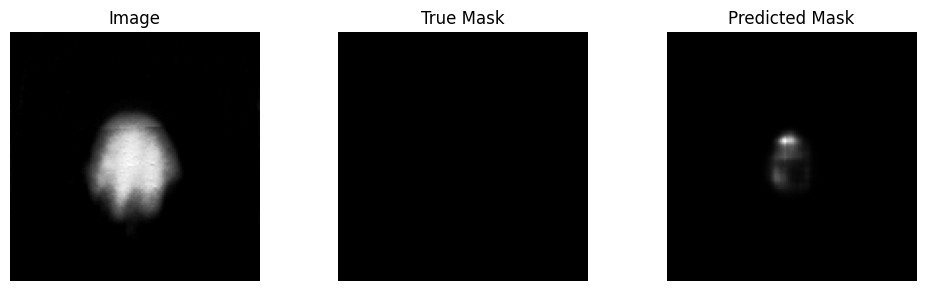

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


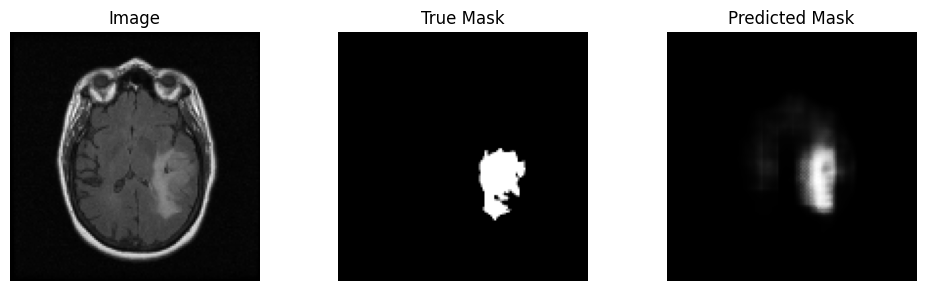

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


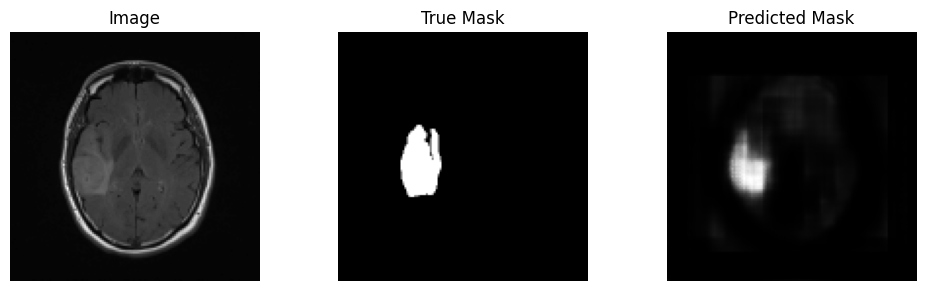

In [8]:
def show_prediction(index):
    img = X_val[index]
    true_mask = y_val[index]
    pred_mask = model.predict(img[np.newaxis, ...])[0]

    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

for i in range(3):
    show_prediction(i)

**8. Predict on New Test Images**

Found 6 test images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


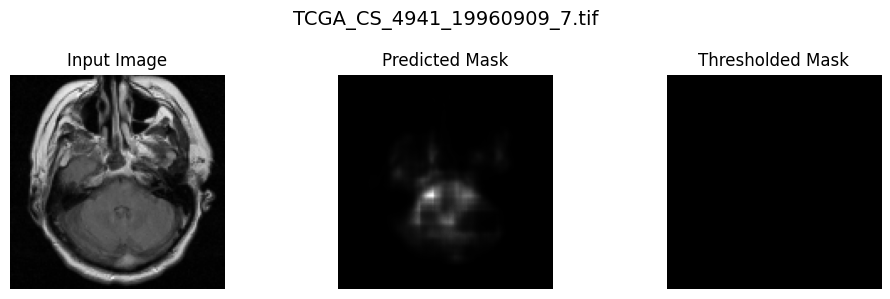

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


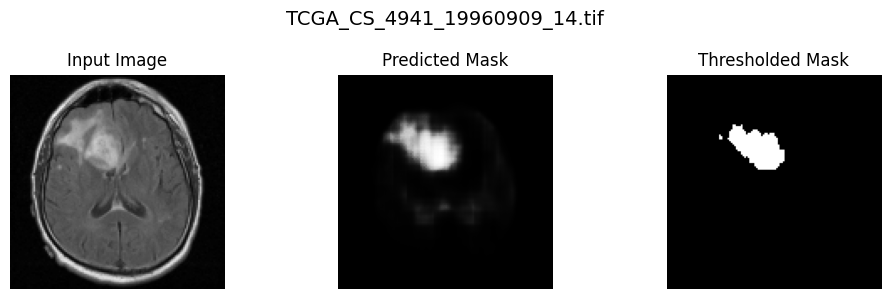

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


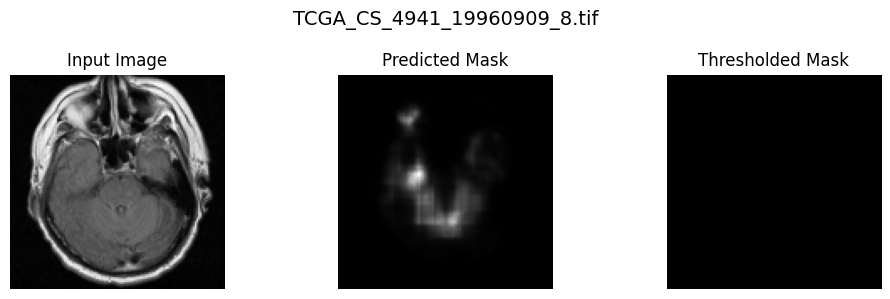

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


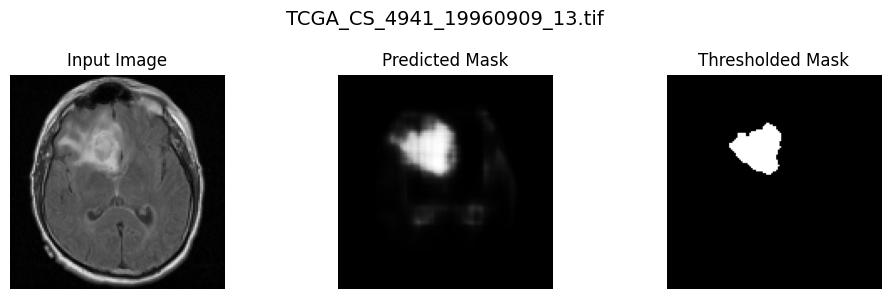

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


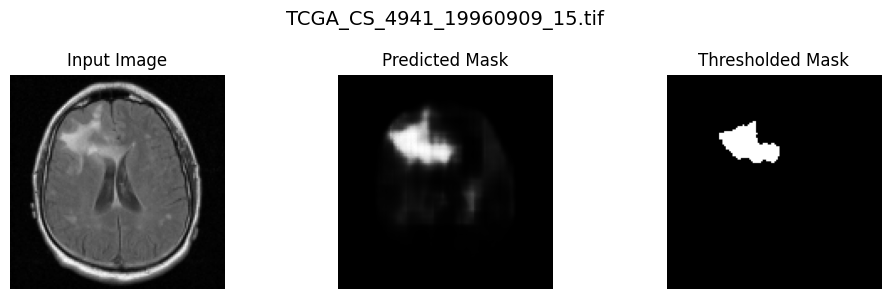

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


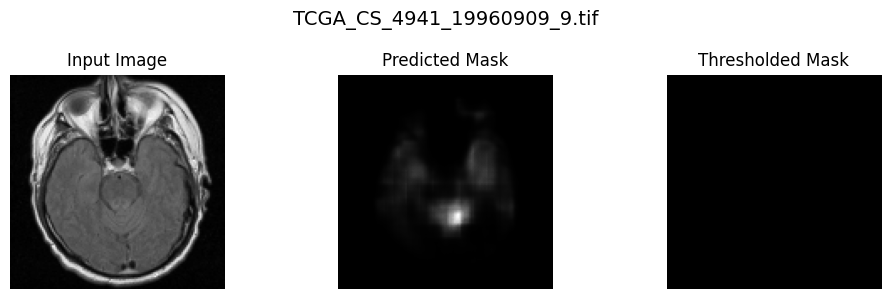

In [12]:
test_dir = "/kaggle/input/datatest/Test"
image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'))]
print(f"Found {len(image_files)} test images.")

for file_name in image_files:
    img_path = os.path.join(test_dir, file_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        continue

    img_resized = cv2.resize(img, (128, 128)) / 255.0
    img_input = img_resized[np.newaxis, ..., np.newaxis]

    pred_mask = model.predict(img_input)[0]
    pred_binary = (pred_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(10, 3))
    plt.suptitle(f"{file_name}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(img_resized, cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_binary.squeeze(), cmap='gray')
    plt.title("Thresholded Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()